In [1]:
import tensorflow as tf
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split#split
iris = datasets.load_iris()#高度统一，如datasets.load_boston()
iris_X = iris.data#注意没有括号，都仅是一个属性
iris_y = iris.target
iris_dataSet = np.column_stack((iris_X[:120],iris_y[:120]))
iris_dataSet= iris_dataSet.tolist()
iris_labels = ['sepal length', 'sepal width','petal length' ,'petal width']
sepal_len = [row[0] for row in iris_dataSet]

In [2]:
from math import log

def cacuEnt(dataSet):
    count = {}
    D = len(dataSet)
    for row in dataSet:
        if row[-1] not in count.keys():
            count[row[-1]] = 1
        else:
            count[row[-1]] += 1
    Ent = 0.0
    for key in count:
        prob = float(count[key])/D
        Ent -= prob*log(prob,2)
    return Ent
print(cacuEnt(iris_dataSet))


1.4833557549816874


In [3]:
#选取某个属性中,值为value的数据集返回,即选择Dv
def select_by_featureVal(dataSet,axis,value):
    select_dataSet = []
    for row in dataSet:
        #具体到某列数值.通过遍历所有行选中
        if row[axis] == value:
            pre_to_axis = row[:axis]
            after_axis = row[axis+1:]
            #在原数组上修改,不能新定义conbine = pre_to_axis.extend(after_axis)
            pre_to_axis.extend(after_axis)
            select_dataSet.append(pre_to_axis)
    return select_dataSet
print(select_by_featureVal(iris_dataSet,0,4.9))

[[3.0, 1.4, 0.2, 0.0], [3.1, 1.5, 0.1, 0.0], [3.1, 1.5, 0.1, 0.0], [3.1, 1.5, 0.1, 0.0], [2.4, 3.3, 1.0, 1.0], [2.5, 4.5, 1.7, 2.0]]


In [4]:
#输入:最后一列为label值的数据集
def choose_feature_split(dataSet):
    #取每列算一下信息增益,再返回最大的那一列
    numFeature = len(dataSet[0]) -1
    baseEnt = cacuEnt(dataSet)
    max_Gain = 0
    selected_Feature = -1
    
    for i in range(numFeature):
        featureVec = [row[i] for row in dataSet]#得到某个特征下所有值（某列）
        Gain_a = 0
        #取出这一列为了取无重复的属性值
        unique_featureVec = set(featureVec)
        print(set(unique_featureVec))#每一列的属性可取值
        Ent_Dv = 0
        gain_ratio_IV = 0
        for value in unique_featureVec:
            #几个属性取值分割几个Dv分支,色泽（青绿,乌黑,浅白）
            Dv = select_by_featureVal(dataSet,i,value)#等于value的分支集合Dv
            prob = len(Dv)/float(len(dataSet))
            Ent_Dv += prob*cacuEnt(Dv)
            gain_ratio_IV -= prob*log(prob,2)#抑制ID3取含样本更多属性作为的偏好
        Gain_a = baseEnt - Ent_Dv#用属性a划分D带来的信息增益
        #Gain_a = Gain_a/gain_ratio_IV
        
        if(Gain_a>max_Gain):
            max_Gain = Gain_a
            selected_Feature = i
    return selected_Feature
choose_feature_split(iris_dataSet)

{4.7, 5.5, 6.3, 5.0, 4.9, 5.1, 4.6, 5.4, 4.4, 4.8, 5.8, 7.0, 7.1, 4.5, 5.9, 5.6, 6.9, 6.6, 6.5, 6.4, 6.0, 6.1, 7.6, 4.3, 5.7, 5.3, 5.2, 6.7, 6.2, 6.8, 7.3, 7.2, 7.7}
{2.9, 3.0, 3.5, 3.2, 3.6, 3.1, 3.9, 3.4, 3.7, 4.0, 4.4, 4.1, 2.0, 2.5, 2.3, 2.8, 2.7, 2.2, 3.8, 3.3, 4.2, 2.6, 2.4}
{1.7, 1.4, 1.6, 1.3, 1.5, 1.1, 1.2, 1.0, 1.9, 4.7, 4.5, 4.9, 4.0, 5.0, 6.0, 3.5, 3.0, 4.6, 4.4, 4.1, 5.1, 5.9, 5.6, 5.5, 6.6, 6.1, 6.9, 3.6, 3.3, 3.8, 3.7, 4.2, 4.8, 4.3, 5.8, 5.3, 6.3, 6.7, 3.9}
{0.2, 0.4, 0.3, 0.5, 0.6, 1.4, 1.5, 1.3, 1.6, 1.0, 1.1, 2.5, 2.0, 2.2, 2.3, 1.8, 0.1, 1.9, 2.1, 2.4, 1.2, 1.7}


2

In [5]:
import operator
#投票表决代码
def majorityCnt(classList):
    classCount={}
    for vote in classList:
        if vote not in classCount.keys():classCount[vote]=0
        classCount[vote]+=1
    sortedClassCount=sorted(classCount.items,key=operator.itemgetter(1),reversed=True)
    return sortedClassCount[0][0]

def createTree(dataSet,labels):
    classList = [row[-1] for row in dataSet]#类别取出来
    #最后一个类别个数等于总长（就一个类别剩下）
    if classList.count(classList[-1]) == len(classList):
        return classList[-1]
     #长度为1，返回出现次数最多的类别
#     if len(classList[0]) == 1:
#         return majorityCnt(classList)
    bestFeat = choose_feature_split(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])#原label上操作
    featValues = [row[bestFeat] for row in dataSet]#取特征对应的那一列
    uniqueVals = set(featValues)
    
    for value in uniqueVals:
        subLabels = labels[:]#子集合
        myTree[bestFeatLabel][value] = createTree(select_by_featureVal(dataSet,bestFeat,value),subLabels)
    return myTree
myTree = createTree(iris_dataSet,iris_labels)
iris_labels

{4.7, 5.5, 6.3, 5.0, 4.9, 5.1, 4.6, 5.4, 4.4, 4.8, 5.8, 7.0, 7.1, 4.5, 5.9, 5.6, 6.9, 6.6, 6.5, 6.4, 6.0, 6.1, 7.6, 4.3, 5.7, 5.3, 5.2, 6.7, 6.2, 6.8, 7.3, 7.2, 7.7}
{2.9, 3.0, 3.5, 3.2, 3.6, 3.1, 3.9, 3.4, 3.7, 4.0, 4.4, 4.1, 2.0, 2.5, 2.3, 2.8, 2.7, 2.2, 3.8, 3.3, 4.2, 2.6, 2.4}
{1.7, 1.4, 1.6, 1.3, 1.5, 1.1, 1.2, 1.0, 1.9, 4.7, 4.5, 4.9, 4.0, 5.0, 6.0, 3.5, 3.0, 4.6, 4.4, 4.1, 5.1, 5.9, 5.6, 5.5, 6.6, 6.1, 6.9, 3.6, 3.3, 3.8, 3.7, 4.2, 4.8, 4.3, 5.8, 5.3, 6.3, 6.7, 3.9}
{0.2, 0.4, 0.3, 0.5, 0.6, 1.4, 1.5, 1.3, 1.6, 1.0, 1.1, 2.5, 2.0, 2.2, 2.3, 1.8, 0.1, 1.9, 2.1, 2.4, 1.2, 1.7}
{4.9, 5.6, 6.0, 5.7, 6.4, 6.2, 5.4}
{2.9, 3.0, 2.8, 3.2, 2.2, 3.4, 2.5}
{1.7, 1.5, 1.6, 1.3}
{5.7, 6.7, 6.0}
{2.5, 3.0, 2.2}
{1.7, 2.0, 1.5}
{5.8, 6.0, 6.5}
{2.7, 3.2, 2.8}
{1.6, 2.0, 2.4, 1.9}


['sepal length', 'sepal width', 'petal width']

In [6]:
def classify(inputTree,featLabels,testVec):
    rootNode = list(inputTree.keys())[0]#字典.keys方法
    secondDict = inputTree[rootNode]#dict[key]进入value,即子树
    featIndex = featLabels.index(rootNode)#决策树第一层在labels[]的位置
    for key in secondDict.keys():#对比根节点分支中每个节点的属性值,分支以第二层字典储存
        if testVec[featIndex] == key:#找到对应的属性值
            if type(secondDict[key]).__name__=='dict':#还有属性值递归下去
                classLabel=classify(secondDict[key],featLables,testVec)
            else:classLabel=secondDict[key]#只有类别返回类别即可
    return classLabel
iris_labels = ['sepal length', 'sepal width','petal length' ,'petal width']
print(iris_dataSet[1])
classify(myTree,iris_labels,[4.9,3.0,1.4,0.2])
for i in range(20,50):
    tf.reduce_mean(tf.cast(tf.equal(classify(myTree,iris_labels,iris_X[i]),iris_y[i]),tf.float32))


[4.9, 3.0, 1.4, 0.2, 0.0]


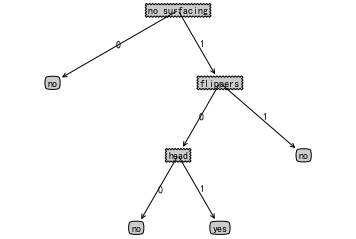

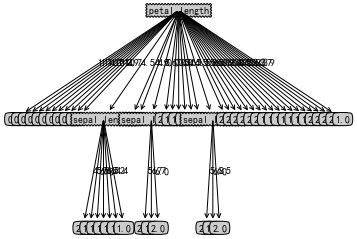

In [7]:
import  matplotlib.pyplot as plt
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei'] #否则中文无法正常显示

decisionNode=dict(boxstyle='sawtooth',fc='0.8') #决策点样式
leafNode = dict(boxstyle='round4',fc='0.8')#叶节点样式
arrow_args = dict(arrowstyle='<-') #箭头样式

def plotNode(nodeTxt,centerPt,parentPt,nodeType):
    createPlot.ax1.annotate(nodeTxt,xy=parentPt,xycoords='axes fraction',
                            xytext=centerPt,textcoords='axes fraction',
                            va='center',ha='center',bbox=nodeType,arrowprops=arrow_args)

def createPlot():
    fig=plt.figure(1,facecolor='white')
    fig.clf()
    createPlot.ax1=plt.subplot(111,frameon=False)
    plotNode('决策节点',(0.5,0.1),(0.1,0.5),decisionNode)
    plotNode('叶节点',(0.8,0.1),(0.3,0.8),leafNode)
    plt.show()

#测试
#获取叶节点数量（广度）
def getNumLeafs(myTree):
    numLeafs=0
    firstStr=list(myTree.keys())[0]#'dict_keys' object does not support indexing
    secondDict=myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            numLeafs+=getNumLeafs(secondDict[key])
        else:numLeafs+=1
    return numLeafs

#获取树的深度的函数（深度）
def getTreeDepth(myTree):
    maxDepth=0
    firstStr=list(myTree.keys())[0]
    secondDict=myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            thisDepth=1+getTreeDepth(secondDict[key])
        else: thisDepth=1
        if thisDepth > maxDepth:
            maxDepth=thisDepth
    return maxDepth
#定义一个预先创建树的函数
def retrieveTree(i):
    listOfTrees=[{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                 {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head':{0:'no', 1: 'yes'}},1:'no'}}}}
                 ]
    return listOfTrees[i]

#定义在父子节点之间填充文本信息的函数
def plotMidText(cntrPt,parentPt,txtString):
    xMid=(parentPt[0]-cntrPt[0])/2+cntrPt[0]
    yMid=(parentPt[1]-cntrPt[1])/2+cntrPt[1]
    createPlot.ax1.text(xMid,yMid,txtString)

#定义树绘制的函数    
def plotTree(myTree,parentPt,nodeTxt):
    numLeafs=getNumLeafs(myTree)
    depth=getTreeDepth(myTree)
    firstStr=list(myTree.keys())[0]
    cntrPt=(plotTree.xOff+(1.0+float(numLeafs))/2/plotTree.totalW,plotTree.yOff)
    plotMidText(cntrPt,parentPt,nodeTxt)
    plotNode(firstStr,cntrPt,parentPt,decisionNode)
    secondDict=myTree[firstStr]
    plotTree.yOff=plotTree.yOff -1/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            plotTree(secondDict[key],cntrPt,str(key))
        else:
            plotTree.xOff=plotTree.xOff+1.0/plotTree.totalW
            plotNode(secondDict[key],(plotTree.xOff,plotTree.yOff),cntrPt,leafNode)
            plotMidText((plotTree.xOff,plotTree.yOff),cntrPt,str(key))
    plotTree.yOff=plotTree.yOff+1/plotTree.totalD

 #定义主函数，来调用其它函数   
def createPlot(inTree):
    fig=plt.figure(1,facecolor='white')
    fig.clf()
    axprops=dict(xticks=[],yticks=[])
    createPlot.ax1=plt.subplot(111,frameon=False,**axprops)
    plotTree.totalW=float(getNumLeafs(inTree))
    plotTree.totalD=float(getTreeDepth(inTree))
    plotTree.xOff=-0.5/plotTree.totalW;plotTree.yOff=1.0;
    plotTree(inTree,(0.5,1.0),'')
    plt.show()
createPlot(retrieveTree(1))
createPlot(myTree)

In [8]:
+
            